<a href="https://colab.research.google.com/github/Minseo-202103621/machinelearning_deeplearning/blob/main/CH)08_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 합성곱 신경망을 사용한 이미지 분류
## 케라스 API를 사용해 합성곱 신경망 모델을 만들어 패션 MNIST 이미지를 분류하는 방법을 배운다.

텐서플로 케라스 API를 사용해 7장에서 만들었던 패션 MNIST 데이터를 합성곱 신경망으로 분류해 보겠다.

---

# 패션 MNIST 데이터 불러오기

데이터 스케일을 0 ~ 255사이에서 0~1 사이로 바꾸고 훈련 세트와 검증 세트로 나눈다.

이전과 다른 점은 차원 처리 부분이다.

완전 연결 신경망에서는 입력 이미지를 밀집층에 연결하기 위해 일렬로 펼쳐야 한다. 이 작업을 위해 넘파이 reshape()메서드를 사용하거나 Flatten 클래스를 사용했다.

하지만 합성곱 신경망은 2차원 이미지를 그대로 사용하기 때문에 이렇게 일렬로 펼치지 않는다.

하지마안 입력 이미지는 항상 깊이(채널) 차원이 있어야 한다. 흑배 이미지의 경우 채널 차원이 없는 2차원 배열이지만 Conv2D 층을 사용하기 위해 마지막에 이 채널 차원을 추가해야 한다.

 넘파이 reshape() 메서드를 사용해 전체 배열 차원을 그대로 유지하면서 마지막에 차원을 간단히 추가할 수 있다.




In [ ]:
from tensorflow import keras
from sklearn.model_selection import train_test_split
(train_input,train_target),(test_input,test_target) = keras.datasets.fashion_mnist.load_data()
train_scaled = train_input.reshape(-1,28,28,1)/255.0
train_scaled,val_scaled,train_target,val_target = train_test_split(train_scaled,train_target,test_size=0.2,random_state=42)


4422102/4422102 [==============================] - 0s 0us/step


이제 (48000,28,28) 크기인 train_input이 (48000,28,28,1) 크기인 train_scaled가 되었다.


---

# 합성곱 신경망 만들기

합성곱 신경망의 구조는 합성곱 층으로 이미지에서 특징을 감지한 후 밀집층으로 클래스에 따른 분류 확률을 계산한다. 케라스의 Sequential 클래스를 사용해 순서대로 이 구조를 정의해 보겠다.

먼저 Seqential 클래스의 객체를 만들고 첫 번째 합성곱 층인 Conv2D를 추가한다. 이 클래스는 다른 층 클래스와 마찬가지로 keras.layers 패키지 아래에 있다. 여기에서는 이전 장에서 보았던 모델의 add() 메서드를 사용해 층을 하나씩 차례대로 추가하겠다.

In [ ]:
model = keras.Sequential()
model.add(keras.layers.Conv2D(32,kernel_size=3,activation='relu',padding='same',input_shape=(28,28,1)))


이 코드의 매개변수를 자세히 살펴보겠다.

이 합성곱 층은 32개의 필터를 사용한다. 커널의 크기는(3,3)이고 렐루 활성화 함수와 세임 패딩을 사용한다.

완전 연결 신경망에서처럼 케라스 신경망 모델의 첫 번째 층에서 입력의 차원을 지정해 주어야 한다. input_shape매개변수를 사용해서 이 값을 지정했다.

그다음 풀링 층을 추가한다. 케라스는 최대 풀링과 평균 풀링을 keras.layers 패키지 아래 MaxPooling2D와 AveragePooling2D 클래스로 제공한다. 전형적인 풀링 크기인 (2,2) 풀링을 사용해 보자. Conv2D 클래스의 kernel_size처럼 가로세로 크기가 같으면 정수 하나로 지정할 수 있다.



In [ ]:
model.add(keras.layers.MaxPooling2D(2))

패션 MNIST 이미지가 (28,28) 크기에 세임 패딩을 적용했기 때문에 합성곱 층에서 출력된 특성 맵의 가로세로 크기는 입력과 동일하다. 그 다음 (2,2) 풀링을 적용했으므로 특성 맵의 크기는 절반으로 줄어든다.

합성곱 층에서 32개의 필터를 사용했기 때문에 이 특성 맵의 깊이는 32가 된다.

따라서 최대 풀링을 통과한 특성 맵의 크기는 (14,14,32)가 된다. 나중에 각 층의 출력 크기를 summary() 메서드로 확인해 보겠다.

첫 번째 합성곱 풀링 층 다음에 두 번째 합성곱 풀링 층을 추가해 보겠다. 두 번째 합성곱-풀링 층은 첫 번째와 거의 동일하다. 필터의 개수를 64개로 늘린 점만 다르다.

In [ ]:
model.add(keras.layers.Conv2D(64,kernel_size=3, activation = 'relu',padding='same'))
model.add(keras.layers.MaxPooling2D(2))

첫 번째 합성곱-풀링 층과 마찬가지로 이 합성곱 층은 세임 패딩을 사용한다. 따라서 입력의 가로세로 크기를 줄이지 않는다. 이어지는 풀링 층에서 이 크기를 절반으로 줄인다. 64개의 필터를 사용했으므로 최종적으로 만들어지는 특성 맵의 크기는 (7,7,64)가 될 것이다.

이제 이 3차원 특성 맵을 일렬로 펼칠 차례이다. 이렇게 하는 이유는 마지막에 10개의 뉴런을 가진 (밀집) 출력층에서 확률을 계산하기 때문이다. 여기에서는 특성 맵을 일렬로 펼쳐서 바로 출력층에 전달하지 않고 중간에 하나의 밀집 은닉층을 하나 더 두도록 하겠다. 즉 Flatten 클래스 다음에 Dense 은직층, 마지막으로 Dense 출력층의 순서대로 구성한다.



In [ ]:
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(100,activation = 'relu'))
model.add(keras.layers.Dropout(0.4))
model.add(keras.layers.Dense(10,activation='softmax'))


은닉층과 출력층 사이에 드롭아웃을 넣었다. 드롭아웃 층이 은닉층의 과대적합을 막아 성능을 조금 더 개선해 줄것이다.

은닉층은 100개의 뉴런을 사용하고 활성화 함수는 합성곱 층과 마찬가지로 렐루 함수를 사용한다.

패션 MNIST 데이터셋은 클래스 10개를 분류하는 다중 분류 문제이므로 마지막 층의 활성화 함수는 소프트맥스를 사용한다.

이렇게 합성곱 신경망의 구성을 마쳤다.

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 7, 7, 64)         0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 3136)              0         
                                                                 
 dense (Dense)               (None, 100)               3

summary() 메서드의 출력 결과를 보면 합성곱 층과 풀링 층의 효과가 잘 나타나 있다.

첫 번째 합성곱 층을 통과하면서 특성 맵의 깊이는 32가 되고 두 번째 합성곱에서 특성 맵의 크기가 64로 늘어난다.

반면 특성 맵의 가로세로 크기는 첫 번째 풀링 층에서 절반으로 줄어들고 두 번째 풀링 층에서 다시 절반으로 더 줄어든다. 따라서 최종 특성 맵의 크기는 (7,7,64)이다.

완전 연결 신경망에서 했던 것처럼 모델 파라미터의 개수를 계산해 보겠다.

첫 번째 합성곱 층은 32개의 필터를 가지고 있고 크기가 (3,3), 깊이가 1이다. 또 필터마다 하나의 절편이 있다.

따라서 총 3 X 3 X 1 X 32 X + 32 = 320개의 파라미터가 있다.

두 번째 합성곱은 64개의 필터를 사용하고 크기가 (3,3),깊이가 32이다. 역시 필터마다 하나의 절편이 있다.

따라서 총 3 X 3 X 32 X 64 + 64 = 18,496개의 파라미터가 있다.

Flatten 클래스에서 (7,7,64) 크기의 특성 맵을 1차원 배열로 펼치면(3136,) 크기의 배열이 된다. 이를 100개의 뉴런과 완전히 연결해야 하므로 은닉층의 모델 파라미터 개수는 3,136 X 100 + 100 = 313,700개이다. 마찬가지 방식으로 계산하면 마지막 출력층의 모델 파라미터 개수는 1,010개이다.


* 케라스는 층의 구성을 그림으로 표현해 주는 plot_model() 함수를 keras.utils 패키지에서 제공한다.

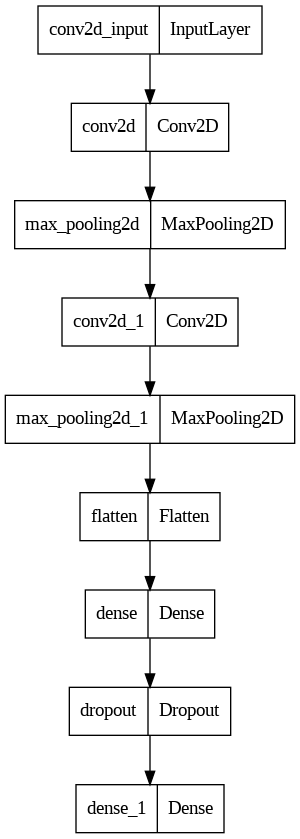

In [ ]:
keras.utils.plot_model(model)

네모 상자 안의 내용 중 콜론 왼쪽에는 층의 이름이 쓰여 있고 오른쪽에는 클래스가 나타난다. 맨 처음에 나오는 InputLayer 클래스는 케라스가 자동으로 추가해 주는 것으로 입력층의 역할을 한다. 이 입력층은 첫 번째 Conv2D 클래스에 추가한 Input_shape 매개변수를 사용한다.

polt_model() 함수의 show_shapes 매개변수를 True로 설정하면 이 그림에 입력과 출력의 크기를 표시해 준다. 또 to_file 매개변수에 파일 이름을 지정하면 출력한 이미지를 파일로 저장한다. dpi 매개변수로 해상도를 지정할 수도 있다.
* 이 옵션들을 사용해 다시 그래프를 그려 보겠다


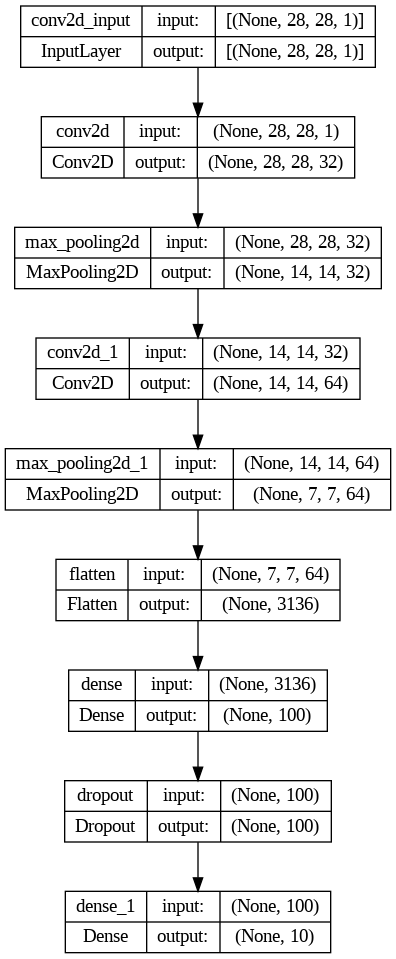

In [ ]:
keras.utils.plot_model(model,show_shapes= True)

<그림>

패션 MNIST 데이터에 적용할 합성곱 신경망 모델의 구성을 마쳤다. 이제 모델을 컴파일하고 훈련해 보겠다.

---

# 모델 컴파일과 훈련

케라스 API의 장점은 딥러닝 모델의 종류나 구성 방식에 상관없이 컴파일과 훈련 과정이 같다는 점이다.

다음 코드는 7장 3절에서 사용했던 완전 연결 신경망 모델을 컴파일하고 훈련하는 코드와 거의 같다.

* Adam 옵티마이저를 사용하고 ModelCheckpoint 콜백과 EarlyStopping 콜백을 함께 사용해 조기 종료 기법을 구현한다.

In [ ]:
model.compile(optimizer = 'adam',loss = 'sparse_categorical_crossentropy',metrics='accuracy')
checkpoint_cb = keras.callbacks.ModelCheckpoint('best-cnn-model.h5',save_best_only = True)
early_stopping_cb = keras.callbacks.EarlyStopping(patience=2,restore_best_weights = True)
history = model.fit(train_scaled,train_target,epochs=20,validation_data = (val_scaled,val_target),callbacks = [checkpoint_cb,early_stopping_cb])

Epoch 1/20
1500/1500 [==============================] - 84s 55ms/step - loss: 0.5268 - accuracy: 0.8123 - val_loss: 0.3519 - val_accuracy: 0.8726
Epoch 2/20
1500/1500 [==============================] - 89s 59ms/step - loss: 0.3555 - accuracy: 0.8735 - val_loss: 0.2958 - val_accuracy: 0.8907
Epoch 3/20
1500/1500 [==============================] - 84s 56ms/step - loss: 0.3054 - accuracy: 0.8897 - val_loss: 0.2663 - val_accuracy: 0.8998
Epoch 4/20
1500/1500 [==============================] - 83s 55ms/step - loss: 0.2715 - accuracy: 0.9031 - val_loss: 0.2465 - val_accuracy: 0.9078
Epoch 5/20
1500/1500 [==============================] - 84s 56ms/step - loss: 0.2488 - accuracy: 0.9093 - val_loss: 0.2374 - val_accuracy: 0.9122
Epoch 6/20
1500/1500 [==============================] - 83s 56ms/step - loss: 0.2287 - accuracy: 0.9161 - val_loss: 0.2267 - val_accuracy: 0.9190
Epoch 7/20
1500/1500 [==============================] - 110s 74ms/step - loss: 0.2090 - accuracy: 0.9236 - val_loss: 0.2236 

얼핏 보아도 훈련 세트의 정확도가 이전보다 훨씬 좋아진 것을 알 수 있다.

* 손실 그래프를 그려서 조기 종료가 잘 이루어졌는지 확인해 보겠다.

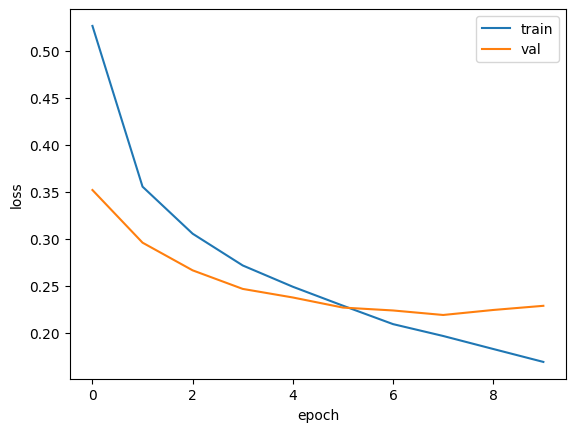

In [ ]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train','val'])
plt.show()

검증 세트에 대한 손실이 점차 감소하다가 정체되기 시작하고 훈련 세트에 대한 손실은 점점 더 낮아지고 있다. 이 그래프를 기반으로  8번째 에포크를 최적으로 생각할 수 있다.

EarlyStopping 클래스에서 restore_best_weights 매개변수를 True로 지정했으므로 현재 model 객체가 최적의 모델 파라미터로 복원되어 있다. 즉 ModelCheckpoint 콜백이 저장한 best-cnn-model.h5 파일을 다시 읽을 필요가 없다.

* 이번에는 세트에 대한 성능을 평가해 보겠다.

In [ ]:
model.evaluate(val_scaled,val_target)

375/375 [==============================] - 5s 14ms/step - loss: 0.2188 - accuracy: 0.9211


[0.21877066791057587, 0.9210833311080933]

이 결과는 fit() 메서드의 출력 중 아홉 번째 에포크의 출려과 동일하다.

EarlyStopping 콜백이 model 객체를 최장의 모델 파라미터로 잘 복원한 것 같다.

predict() 메서드를 사용해 훈련된 모델을 사용하여 새로운 데이터에 대해 예측을 만들어 보겠다. 여기에서는 편의상 검증 세트의 첫 번째 샘플을 처음 본 이미지라고 가정한다. 맷플롯립에서는 흑백 이미지에 깊이 차원은 없다. 따라서 (28,28,1) 크기를 (28,28)로 바꾸어 출력해야 한다.


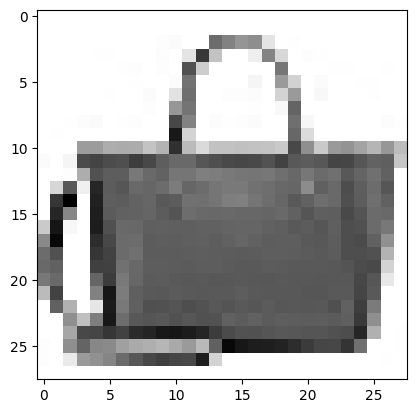

In [ ]:
plt.imshow(val_scaled[0].reshape(28,28),cmap='gray_r')
plt.show()

핸드백 이미지이다. 모델은 이 이미지에 대해 어떤 예측을 만드는지 확인해 보자.

predict() 메서드는 10개의 클래스에 대한 예측 확률을 출력한다.

In [ ]:
preds = model.predict(val_scaled[0:1])
print(preds)

1/1 [==============================] - 0s 202ms/step
[[1.01178665e-17 1.15256293e-20 4.19442273e-19 8.17103278e-19
  2.34979265e-17 3.07060836e-15 8.48792552e-16 6.21211658e-19
  1.00000000e+00 1.77675455e-20]]


>> 왜 슬라이싱을 사용했나? : predict() 메서드에 데이터를 전달할 때 val_scaled[0]로 쓰지 않고 val_scaled[0:1]와 같이 슬라이싱을 했다. 케라스의 fit(),predict(),evaluate() 메서드는 모두 입력의 첫 번째 차원이 배치 차원일 것으로 기대한다. 따라서 샘플 하나를 전달할 때 (28,28,1)이 아니라 (1,28,28,1) 크기를 전달해야 한다. 배열 슬라이싱은 인덱싱과 다르게 선택된 원소가 하나이더라도 전체 차원이 유지되어(1,28,28,1) 크기를 만든다.

출력 결과를 보면 아홉 번째 값이 1이고 다른 값은 거의 0에 가깝다. 다시 말해 아홉 번째 클래스라고 강하게 주장하는 거다. 이를 막대그래프로 그리면 확실하게 느낄 수 있다.


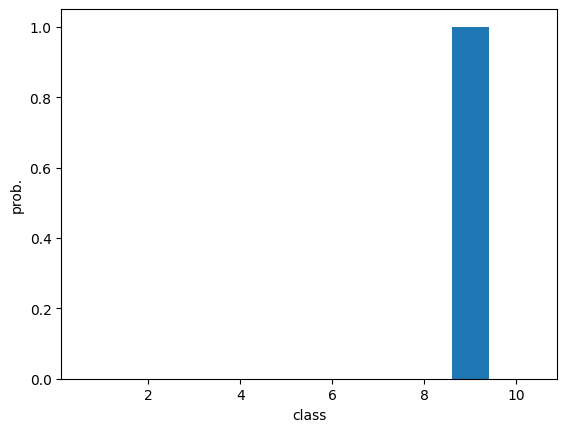

In [ ]:
plt.bar(range(1,11),preds[0])
plt.xlabel('class')
plt.ylabel('prob.')
plt.show()

다른 클래스의 값은 사실상 모두 0이다.

여기에서는 파이썬에서 레이블을 다루기 위해 리스트로 저장하겠다.

In [ ]:
classes = ['티셔츠','바지','스웨터','드레스','코트','샌달','셔츠','스니커즈','가방','앵클 부츠']


클래스 리스트가 있으면 레이블을 출력하기 쉽다. prebs 배열에서 가장 큰 인덱스를 찾아 classes 리스트의 인덱스로 사용하면 된다.

In [ ]:
import numpy as np
print(classes[np.argmax(preds)])


가방


이 샘플을 가방으로 잘 예측한 것 같다. 합성곱 신경망을 만들고 훈련하여 새로운 샘플에 대한 예측을 수행했다.

마지막으로 맨 처음에 뗴어 놓았던 테스트 세트로 합성곱 신경망의 일반화 성능을 가늠해 보겠다.

즉 이 모델을 실전에 투입했을 때 얻을 수 있는 예상 성능을 측정해 보겠다.

* 훈련 세트와 검증 세트에서 했던 것처럼 픽셀값의 범위를 0~1 사이로 바꾸고 이미지 크기를 (28,28)에서 (28,28,1)로 바꾸겠다.

In [ ]:
test_scaled = test_input.reshape(-1,28,28,1) / 255.0


* 그 다음 evaluate() 메서드로 테스트 세트에 대한 성능을 측정한다.


In [ ]:
model.evaluate(test_scaled,test_target)

313/313 [==============================] - 7s 20ms/step - loss: 0.2398 - accuracy: 0.9142


[0.23978295922279358, 0.9142000079154968]